In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import json
import pickle
import re
import seaborn as sns
import networkx as nx
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
import sys
import scipy.stats as ss
import statsmodels.formula.api as smf
import statsmodels as sm
import datetime


from spark_utils import start_spark
from helpers import *   

In [21]:
spark = start_spark(n_threads=24)
PATH_TO_QUOTEGRAPH = 'data/quotegraph.parquet'
PATH_TO_QUOTEGRAPH_WITH_FEATURES = 'data/quotegraph_enriched.parquet'
PATH_TO_PAGERANKS = 'data/pageranks_quotegraph.pkl'
PATH_TO_SPEAKER_ATTRIBUTES = 'data/speaker_attributes.parquet'

In [23]:
qg_plain = spark.read.parquet(PATH_TO_QUOTEGRAPH)
qg = spark.read.parquet(PATH_TO_QUOTEGRAPH_WITH_FEATURES)
sa = spark.read.parquet(PATH_TO_SPEAKER_ATTRIBUTES)
pageranks = load_pickle(PATH_TO_PAGERANKS)

In [15]:
modeling_df = qg\
    .where(~F.isnan('source_age'))\
    .where(~F.isnan('target_age'))\
    .where('source_age >= 10').where('source_age <= 110').where('target_age >= 10').where('source_age <= 110')\
    .withColumn('art', F.array_contains('source_occupation', 'art') & F.array_contains('target_occupation', 'art'))\
    .withColumn('politics', F.array_contains('source_occupation', 'law_politics') & F.array_contains('target_occupation', 'law_politics'))\
    .withColumn('sport', F.array_contains('source_occupation', 'sport') & F.array_contains('target_occupation', 'sport'))\
    .withColumn('art', F.col('art') & ~(F.array_contains('source_occupation', 'law_politics') | F.array_contains('target_occupation', 'law_politics')))\
    .withColumn('sport', F.col('sport'))\
    .withColumn('USA', F.array_contains('source_nationality', 'Q30') & F.array_contains('target_nationality', 'Q30'))\
    .withColumn('India', F.array_contains('source_nationality', 'Q668') & F.array_contains('target_nationality', 'Q668'))\
    .withColumn('UK', F.array_contains('source_nationality', 'Q145') & F.array_contains('target_nationality', 'Q145'))\
    .withColumn('N_Other', ~F.col('USA') & ~F.col('UK') & ~F.col('India'))\
    .withColumn('O_Other', ~F.col('art') & ~F.col('politics') & ~F.col('sport')).toPandas()

25/02/25 22:03:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [25]:
@F.udf(T.ArrayType(T.StringType()))
def concat(source, target):
    return [source, target]

first_name_freq = (qg_plain.select('speaker', 'target').withColumn('node', concat('speaker',
                                                                                'target'))
                   .select(F.explode('node').alias('id')).join(sa.select('id', 'first_name'), on='id').distinct().select(F.explode('first_name').alias('first_name')).groupby('first_name').count().sort('count', ascending=False).toPandas())

last_name_freq = (qg_plain.select('speaker', 'target').withColumn('node', concat('speaker', 'target'))
                  .select(F.explode('node').alias('id')).join(sa.select('id', 'last_name'), on='id').distinct().select(F.explode('last_name').alias('last_name')).groupby('last_name').count().sort('count', ascending=False).toPandas())

first_name_freq = dict(zip(first_name_freq['first_name'], first_name_freq['count']))
last_name_freq = dict(zip(last_name_freq['last_name'], last_name_freq['count']))
reference_types = ['fn_only', 'sn_only', 'full', 'alias']

In [51]:
modeling_df['ln_t'] *= 1
modeling_df['fn_t'] *= 1

modeling_df['full'] = modeling_df['ln_t'] * modeling_df['fn_t']
modeling_df['alias'] = (1 - modeling_df['ln_t']) * (1 - modeling_df['fn_t'])
modeling_df['sn_only'] = modeling_df['ln_t'] * (1 - modeling_df['fn_t'])
modeling_df['fn_only'] = modeling_df['fn_t'] * (1 - modeling_df['ln_t'])

modeling_df['source_female'] = modeling_df['source_gender'] == "Female"
modeling_df['target_female'] = modeling_df['target_gender'] == "Female"
modeling_df['source_male'] = modeling_df['source_gender'] == "Male"
modeling_df['target_male'] = modeling_df['target_gender'] == "Male"

modeling_df['source_pr'] = modeling_df.speaker.apply(lambda x: pageranks[x])
modeling_df['target_pr'] = modeling_df.target.apply(lambda x: pageranks[x])

modeling_df['target_fn'] = modeling_df.target_first_name.apply(lambda x: first_name_freq[x[0]] if len(x) > 0 else 1)
modeling_df['target_ln'] = modeling_df.target_last_name.apply(lambda x: last_name_freq[x[0]] if len(x) > 0 else 1)

modeling_df['target_fn_length'] = modeling_df.target_first_name.apply(lambda x: len(x[0].split(' ')[0]) if len(x) > 0 else 0)
modeling_df['target_ln_length'] = modeling_df.target_last_name.apply(lambda x: len(x[0].split(' ')[0]) if len(x) > 0 else 0)

modeling_df['target_fn_length'] -= 5
modeling_df['target_ln_length'] -= 6

modeling_df['target_pr_rank'] = modeling_df['target_pr'].transform('rank') - 1
modeling_df['target_pr_rank'] /= modeling_df['target_pr_rank'].max()
modeling_df['target_pr_rank'] -= 0.5

modeling_df['target_fn_rank'] = modeling_df['target_fn'].transform('rank') - 1
modeling_df['target_fn_rank'] /= modeling_df['target_fn_rank'].max()
modeling_df['target_fn_rank'] -= 0.5

modeling_df['target_ln_rank'] = modeling_df['target_ln'].transform('rank') - 1
modeling_df['target_ln_rank'] /= modeling_df['target_ln_rank'].max()
modeling_df['target_ln_rank'] -= 0.5

modeling_df['source_pr_rank'] = modeling_df['source_pr'].transform('rank') - 1
modeling_df['source_pr_rank'] /= modeling_df['source_pr_rank'].max()
modeling_df['source_pr_rank'] -= 0.5

modeling_df['source_age'] -= 50
modeling_df['target_age'] -= 50

modeling_df['source_age'] /= 10
modeling_df['target_age'] /= 10

modeling_df['ym_tuple'] = modeling_df[['year', 'month']].apply(lambda x: (x.year, x.month), axis=1)
modeling_df_clean = modeling_df[modeling_df['ym_tuple'] >= (2013, 5)]

ym_unique = sorted(modeling_df_clean.ym_tuple.unique())
ym2id = dict(zip(ym_unique, range(len(ym_unique))))
id2ym = dict(zip(range(len(ym_unique)), ym_unique))

modeling_df_clean['month_index'] = modeling_df_clean.ym_tuple.apply(lambda x: ym2id[x])
modeling_df_clean['month_index'] /= 12

modeling_df_clean = modeling_df_clean.query('source_gender != "Other"').query('target_gender != "Other"')

/tmp/ipykernel_493148/2728422411.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_df_clean['month_index'] = modeling_df_clean.ym_tuple.apply(lambda x: ym2id[x])
/tmp/ipykernel_493148/2728422411.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_df_clean['month_index'] /= 12


In [73]:
import time
import logging
from tqdm import tqdm

def prep_models(data, formula_rhs='C(sport) + C(art) + C(O_Other) + C(India) + C(UK) + C(N_Other) + C(source_female) + C(target_female) + source_age + target_age + source_pr_rank + target_pr_rank + target_fn_rank + target_ln_rank + target_fn_length + target_ln_length + month_index'):
    pbar = tqdm(total=4, desc='Preparing models')
    pbar.refresh()
    model_sn = smf.glm('sn_only ~ ' + formula_rhs, data=data, family=sm.genmod.families.family.Binomial())
    pbar.update(1)
    pbar.refresh()
    model_fn = smf.glm('fn_only ~ ' + formula_rhs, data=data, family=sm.genmod.families.family.Binomial())
    pbar.update(1)
    pbar.refresh()
    model_full = smf.glm('full ~ ' + formula_rhs, data=data, family=sm.genmod.families.family.Binomial())
    pbar.update(1)
    pbar.refresh()
    model_alias = smf.glm('alias ~ ' + formula_rhs, data=data, family=sm.genmod.families.family.Binomial())
    pbar.update(1)
    pbar.refresh()
    return model_sn, model_fn, model_full, model_alias

def fit_all_types(models):
    pbar = tqdm(total=4, desc='Fitting models')
    pbar.refresh()
    res_sn = models[0].fit()
    pbar.update(1)
    pbar.refresh()
    res_fn = models[1].fit()
    pbar.update(1)
    pbar.refresh()
    res_full = models[2].fit()
    pbar.update(1)
    pbar.refresh()
    res_alias = models[3].fit()
    pbar.update(1)
    pbar.refresh()
    return res_fn, res_sn, res_full, res_alias

def plot_coefs(results, delta=0.3, palette=None, labels=None, ylabels=True):
    if labels is None:
        labels = ['FN', 'LN', 'FLN', 'A']
    if palette is None:
        palette = ['#df2935', '#3772ff', '#fdca40', 'lightgrey']
    init = -1.5 * delta
    for i, res in enumerate(results):
        offset = init + i * delta
        means = res.params[1:]
        CIs = res.conf_int(alpha=0.05)
        lowers = CIs[0][1:]
        uppers = CIs[1][1:]
        for j, (m, l, u) in enumerate(zip(means, lowers, uppers)):
            j *= 4
            edgecolors = palette[i]
            facecolors = 'white' if l < 0 < u else palette[i]
            plt.scatter(offset + j, m, edgecolors=edgecolors, facecolors=facecolors, alpha=1, zorder=10, label=labels[i] if facecolors != 'white' else None)
            plt.plot([offset + j, offset + j], [l, u], color=palette[i], zorder=5)
    if ylabels:
        plt.xticks(range(0, len(means) * 4, 4), labels=['$D_{sport}$', '$D_{art}$', '$D_{other}$', '$N_{India}$', '$N_{UK}$', '$N_{other}$',
                                                        '$G_s$', '$G_m$', '$a_s$',  '$a_m$',
                                                        '$r_s$',  '$r_m$', '$f_{FN}$', '$f_{LN}$',
                                                        '$l_{FN}$', '$l_{LN}$', '$t$'], fontsize=20)

    else:
        plt.xticks(range(0, len(means) * 4, 4), labels=[])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(list(by_label.values())[::-1], list(by_label.keys())[::-1], fontsize=18)
    plt.yticks(fontsize=20)
    plt.axhline(0, linestyle='dotted', color='black')
    plt.ylim(-1.5, 1.5)

In [67]:
model_ln, model_fn, model_fln, model_a = prep_models(modeling_df_clean.query('source_gender != "Other"').query('target_gender != "Other"'))
models_all = fit_all_types([model_ln, model_fn, model_fln, model_a])



Fitting models:   0%|                                                                    | 0/4 [00:00<?, ?it/s]

Fitting models:   0%|                                                                    | 0/4 [00:00<?, ?it/s]

Fitting models:  25%|███████████████                                             | 1/4 [00:55<02:47, 55.90s/it]

Fitting models:  25%|███████████████                                             | 1/4 [00:55<02:47, 55.90s/it]

Fitting models:  50%|██████████████████████████████                              | 2/4 [01:52<01:52, 56.20s/it]

Fitting models:  50%|██████████████████████████████                              | 2/4 [01:52<01:52, 56.20s/it]

Fitting models:  75%|█████████████████████████████████████████████               | 3/4 [02:53<00:58, 58.33s/it]

Fitting models:  75%|█████████████████████████████████████████████               | 3/4 [02:53<00:58, 58.33s/it]

Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [03:50<

In [77]:
interactions_gender = prep_models(modeling_df_clean, formula_rhs='C(sport) + C(art) + C(O_Other) '
                                                                 '+ C(India) + C(UK) + C(N_Other) + C(source_female) * C(target_female) + source_age + target_age + source_pr_rank + target_pr_rank +  target_fn_rank + target_ln_rank + target_fn_length + target_ln_length + month_index')

Preparing models: 100%|██████████████████████████████████████████████████████████| 4/4 [03:53<00:00, 58.29s/it]


In [ ]:
def interaction_se(coef, cov):
    ses = []
    for i in range(len(coef)):
        for j in range(len(coef)):
            try:
                ses.append(cov['1'][coef[i]]['1'][coef[j]])
            except KeyError:
                ses.append (cov[coef[i]][coef[j]])
    return np.sqrt(np.sum(ses))

def interaction_coef(coef, params):
    return np.sum(np.array(params.loc[coef]))

In [78]:
res_gender = fit_all_types(interactions_gender)


Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.83s/it]


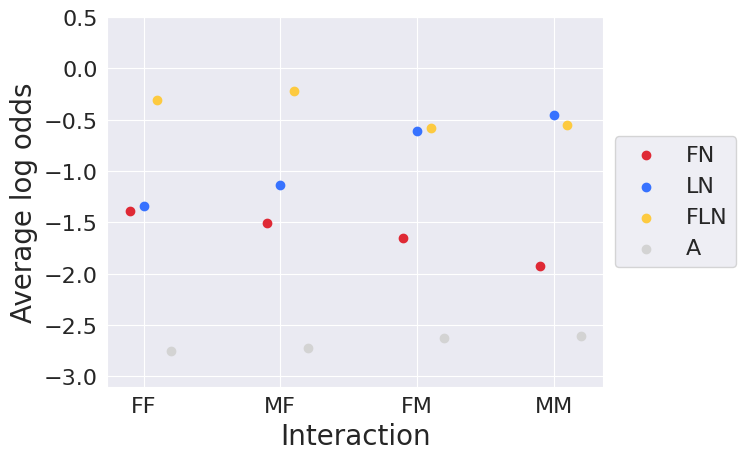

In [79]:
def interaction_se(coef, cov):
    ses = []
    for i in range(len(coef)):
        for j in range(len(coef)):
            try:
                ses.append(cov['1'][coef[i]]['1'][coef[j]])
            except KeyError:
                ses.append (cov[coef[i]][coef[j]])
    return np.sqrt(np.sum(ses))

def interaction_coef(coef, params):
    return np.sum(np.array(params.loc[coef]))


In [134]:
def log_odds_to_probability(coef):
    return np.exp(coef) / (1 + np.exp(coef))

In [ ]:
plot_gender(res_gender)

In [125]:
models_gender_occupations = prep_models(modeling_df_clean, formula_rhs='(C(sport) + C(art) + C(O_Other)) * C'
                                                     '(source_female) * C(target_female) + C(India) + C(UK) + C(N_Other) + C(source_female) * C(target_female) + source_age + target_age + source_pr_rank + target_pr_rank +  target_fn_rank + target_ln_rank + target_fn_length + target_ln_length + month_index')
models_gender_occupations = fit_all_types(models_gender_occupations)


Preparing models: 100%|██████████████████████████████████████████████████████████| 4/4 [04:08<00:00, 62.07s/it]

Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [02:23<00:00, 35.81s/it]


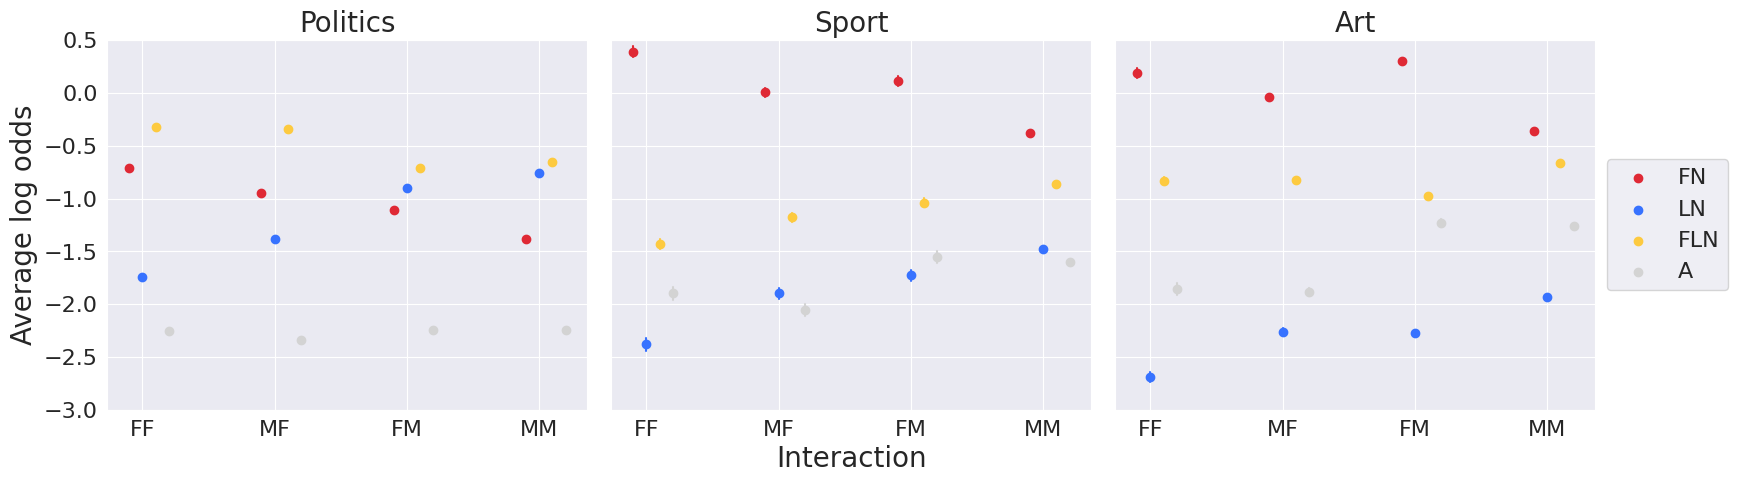

In [137]:
def plot_gender_occupations(models, figsize=None):
    if figsize is None:
        figsize = [6.4 * 3, 4.8]

    domains = ['Politics', 'Sport', 'Art', 'Other']
    ff_coef_domain = [i for i in models[0].params.index if
                      'sport' in i or 'art' in i or 'Intercept' in i or 'female' in i or 'O_Other' in i]
    mf_coef_domain = [i for i in ff_coef_domain if 'source_female' not in i]
    fm_coef_domain = [i for i in ff_coef_domain if 'target_female' not in i]
    mm_coef_domain = [i for i in ff_coef_domain if 'female' not in i]

    def has_any(i, domains):
        for j in domains:
            if j.lower() in i:
                return True
        return False

    m = 1
    plt.figure(figsize=figsize)
    for domain in domains[:-1]:
        other_domains = [i for i in domains if i != domain]
        ff_coef = [i for i in ff_coef_domain if not has_any(i, other_domains)]
        mf_coef = [i for i in mf_coef_domain if not has_any(i, other_domains)]
        fm_coef = [i for i in fm_coef_domain if not has_any(i, other_domains)]
        mm_coef = [i for i in mm_coef_domain if not has_any(i, other_domains)]
        coefs = [ff_coef, mf_coef, fm_coef, mm_coef]
        labels_i = ['FF', 'MF', 'FM', 'MM']

        delta = 0.1
        k = 1
        palette = ['#df2935', '#3772ff', '#fdca40', 'lightgrey']
        labels = ['FN', 'LN', 'FLN', 'A']
        plt.subplot(1, 3, m)
        for coef in coefs:
            offset = k - delta
            for res, color, label in zip(models, palette, labels):
                params = interaction_coef(coef, res.params)
                se = interaction_se(coef, res.cov_params())
                lower = params - 1.96 * se
                upper = params + 1.96 * se
                plt.scatter(offset, params, color=color, label=label, zorder=10)
                plt.plot([offset, offset], [lower, upper], zorder=5, color=color)
                offset += delta
            k += 1

        plt.xticks(range(1, 5), labels_i)

        if m == 1:
            plt.ylabel('Average log odds', fontsize=20)
            plt.yticks(fontsize=16)
        else:
            plt.yticks(np.arange(-3, 1, 0.5), labels=[], fontsize=16)

        if m == 2:
            plt.xlabel('Interaction', fontsize=20)

        m += 1
        plt.xticks(fontsize=16)

        plt.ylim(-3, 0.5)
        plt.title(domain, fontsize=20)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(list(by_label.values()), list(by_label.keys()), fontsize=16, loc='center left',
               bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(wspace=0.05, hspace=0)

plot_gender_occupations(models_gender_occupations)


/dlabscratch1/culjak/git/quotegraph_


In [180]:
@F.udf(T.BooleanType())
def matching_condition(target_gender, ln_t, fn_t, target_last_name):
    if len(target_gender) != 2:
        return False
    if 'Other' in target_gender:
        return False
    if target_gender[0] == target_gender[1]:
        return False
    if len(set(target_last_name[0]).intersection(target_last_name[1])) > 0:
        return False

    return True

@F.udf(T.ArrayType(T.ArrayType(T.StringType())))
def to_arr_arr(arr):
    array = []
    for i in range(2):
        array.append(arr[i::2])

    return array

@F.udf(T.IntegerType())
def ln_only(fn_t, ln_t):
    return bool(ln_t.capitalize()) * (1 - bool(fn_t.capitalize()))

rows_matched = qg\
    .groupby('quoteID')\
    .agg(F.collect_list('target_gender').alias('target_gender'),
         F.collect_list('fn_t').alias('fn_t'),
         F.collect_list('ln_t').alias('ln_t'),
         F.collect_list('target_last_name').alias('last_name'),
         F.collect_list('target').alias('target'))\
    .where(matching_condition('target_gender', 'ln_t', 'fn_t', 'last_name')).collect()

In [182]:
quoteIDs = []
source_genders = []
target_genders = []
targets = []
sn_onlies = []

for row in rows_matched:
    quoteIDs.append(row.quoteID)

df = pd.DataFrame(dict(quoteID=quoteIDs))

In [183]:
matched_df = modeling_df_clean.merge(df.drop_duplicates(), on='quoteID')

In [186]:
counts = matched_df.reset_index().groupby('quoteID').target.count()
counts = counts[counts == 2].reset_index()

matched_df = matched_df.reset_index().merge(counts, on='quoteID')

In [267]:
model_ln, model_fn, model_fln, model_a = prep_models(matched_df)
res_matched = fit_all_types([model_ln, model_fn, model_fln, model_a])

Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s]


In [288]:
model_ln, model_fn, model_fln, model_a = prep_models(matched_df, formula_rhs='C(sport) + C(art) + C(O_Other) '
                                                                 '+ C(India) + C(UK) + C(N_Other) + C(source_female) * C(target_female) + source_age + target_age + source_pr_rank + target_pr_rank +  target_fn_rank + target_ln_rank + target_fn_length + target_ln_length + month_index')
models_gender_matched = fit_all_types([model_ln, model_fn, model_fln, model_a])


Preparing models: 100%|██████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]

Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s]


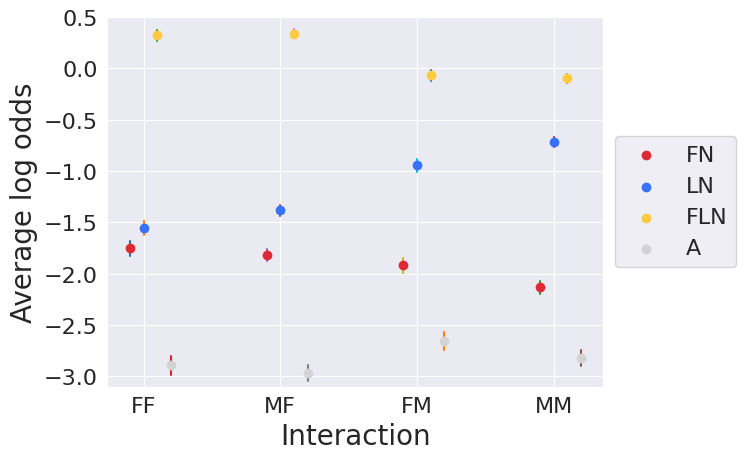

In [289]:
plot_gender(models_gender_matched)

In [270]:
def party_assignment(party):
    if party == 'Q29468':
        return 'Republican'
    if party == 'Q29552':
        return 'Democrat'
    return 'Other'

modeling_df_clean['source_congress'] = modeling_df_clean['source_congress_ID'].apply(lambda x: x is not None)
modeling_df_clean['target_congress'] = modeling_df_clean['target_congress_ID'].apply(lambda x: x is not None)

modeling_df_clean['source_US_party'] = modeling_df_clean['source_party'].apply(party_assignment)
modeling_df_clean['target_US_party'] = modeling_df_clean['target_party'].apply(party_assignment)
modeling_df_clean_us = modeling_df_clean.query('USA==True')

In [275]:
models_usa_politics = prep_models(modeling_df_clean_us.query('source_US_party != "Other"').query
                    ('target_US_party != "Other"'), formula_rhs='C(source_female) + C(target_female) + source_age + target_age + source_pr_rank + target_pr_rank + target_fn_rank + target_ln_rank + target_fn_length + target_ln_length + month_index + C(source_US_party) * C(target_US_party) + C(source_congress) * C(target_congress)')

Preparing models: 100%|██████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]


In [276]:
models_usa_politics = fit_all_types(models_usa_politics)

Fitting models: 100%|████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.31s/it]


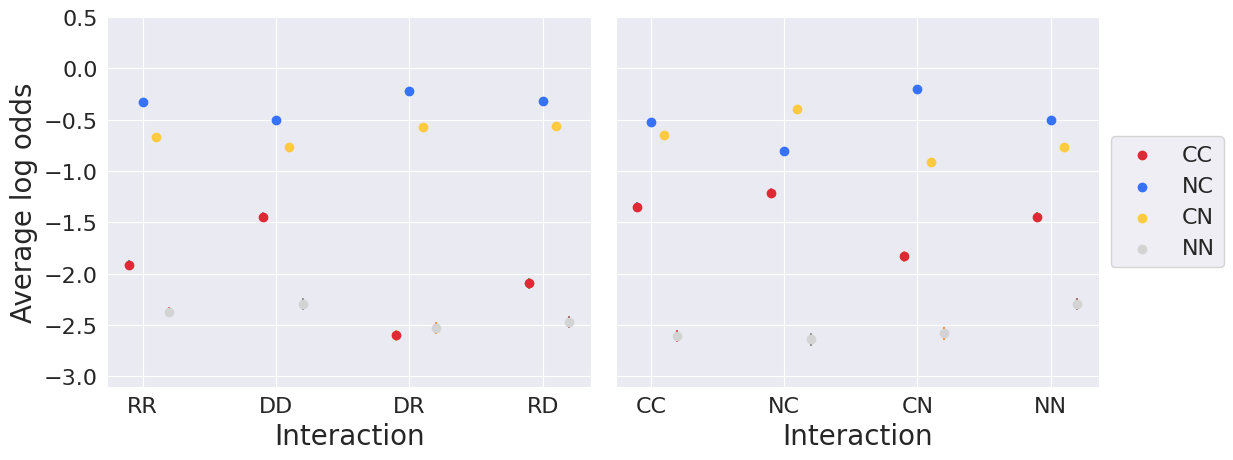

In [284]:
plot_party(models_usa_politics)